## Image classification of Different breeds of Dogs

- GermanShepherd
- LabradorRetriever
- SiberianHusky
- Rottweiler
- Bulldog
- Poddle

In [1]:
# library for computer vision
from fastai.vision.widgets import *

In [2]:
# loading the necessary modules
from fastbook import *

In [1]:
# key for Search Image Bing API
key = '****'

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [5]:
# creating a directory in the path
dog_types = 'GermanShepherd','LabradorRetriever','SiberianHusky','Rottweiler','Bulldog','Poddle'
path = Path('dogs')

In [6]:
# creating a subdirectory if not exist and doing images using API
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('content_url'))

In [7]:
# get the images object
fns = get_image_files(path)
fns

(#884) [Path('dogs/Bulldog/00000000.jpg'),Path('dogs/Bulldog/00000001.jpg'),Path('dogs/Bulldog/00000002.jpg'),Path('dogs/Bulldog/00000003.jpg'),Path('dogs/Bulldog/00000004.jpg'),Path('dogs/Bulldog/00000005.jpg'),Path('dogs/Bulldog/00000006.jpg'),Path('dogs/Bulldog/00000007.jpg'),Path('dogs/Bulldog/00000008.jpg'),Path('dogs/Bulldog/00000009.jpg')...]

Verifying Images, checking whether downloaded file is corrupted or not

In [8]:
# checking for the images that can't be opened
failed = verify_images(fns)
failed

(#0) []

In [9]:
# removing the corrupted images
failed.map(Path.unlink);

In [10]:
# creating a datablock
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
# dataloader object
dls = bears.dataloaders(path)

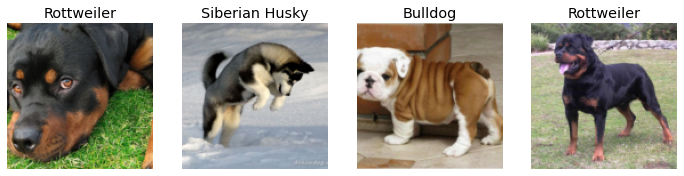

In [12]:
# checking for inconsistencies in the batch
dls.valid.show_batch(max_n=4, nrows=1)

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [13]:
# creating synthetic images with crop
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Creating the learner using Transfer Learning i.e. from already trained model

In [14]:
# passing dataloader object into learner with already trained model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.527701,0.053669,0.017045,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.154253,0.036610,0.005682,00:12
1,0.113880,0.019337,0.005682,00:12
2,0.084192,0.011650,0.005682,00:12
3,0.064374,0.009920,0.005682,00:12


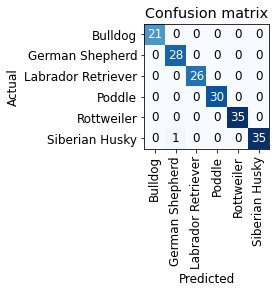

In [15]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [16]:
# Exploring Python widgets within Notebook
# generating upload button
btn_upload = widgets.FileUpload()

In [17]:
btn_upload

FileUpload(value={}, description='Upload')

In [19]:
img = PILImage.create(btn_upload.data[0])

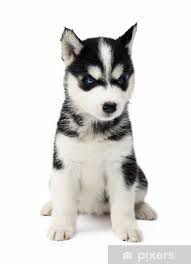

In [20]:
img

In [21]:
# learner prediction for the image
learn.predict(img)

('Siberian Husky',
 tensor(5),
 tensor([2.6043e-06, 3.6966e-06, 2.7978e-07, 1.4209e-06, 3.3885e-07, 9.9999e-01]))

In [22]:
btn_upload

FileUpload(value={'download.jpg': {'metadata': {'name': 'download.jpg', 'type': 'image/jpeg', 'size': 4584, 'l…

In [23]:
img2 = PILImage.create(btn_upload.data[0])

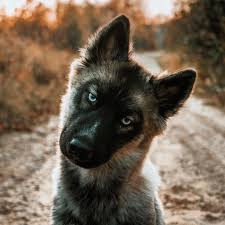

In [24]:
img2

In [25]:
learn.predict(img2)

('German Shepherd',
 tensor(1),
 tensor([7.2059e-06, 9.9711e-01, 1.0334e-05, 7.8445e-05, 9.2759e-06, 2.7801e-03]))

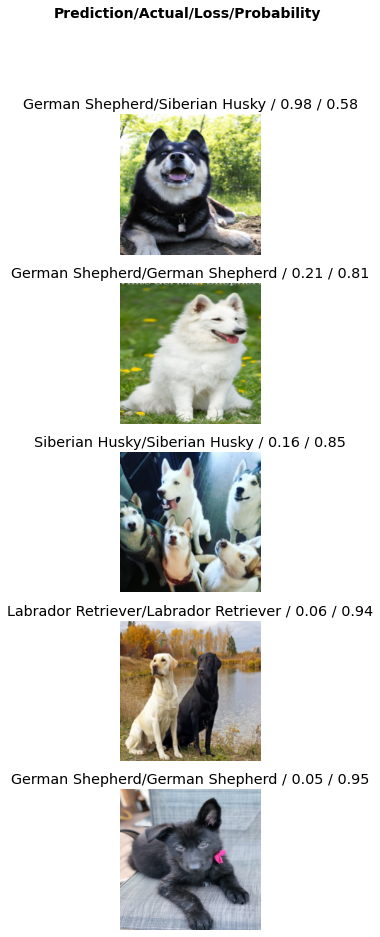

In [26]:
# checking where the model has most discrepancies
interp.plot_top_losses(5, nrows=5)

In [ ]:
## Performing data cleaning after model building as can be seen above it helps easily rectifying  the mistakes with our data

In [27]:
## Image GUI for data cleaning purpose
## only will give the images with the highest loss
cleaner = ImageClassifierCleaner(learn)
cleaner

## Converting the model to an app

In [28]:
# exporting the model to a pickle file
learn.export()

In [29]:
# checking for the pickle file existence
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Creating Inference Model from the saved model

In [30]:
# loading the model for inferecne
learn_inf = load_learner(path/'export.pkl')

In [31]:
btn_upload

FileUpload(value={'download (1).jpg': {'metadata': {'name': 'download (1).jpg', 'type': 'image/jpeg', 'size': …

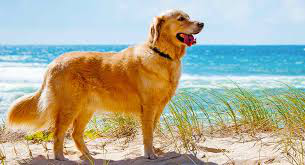

In [33]:
img3 = PILImage.create(btn_upload.data[0])
img3

In [34]:
learn_inf.predict('images/download (2).jpg')

('Labrador Retriever',
 tensor(2),
 tensor([0.0024, 0.0296, 0.4685, 0.2464, 0.0084, 0.2446]))

In [35]:
learn_inf.dls.vocab

(#6) ['Bulldog','German Shepherd','Labrador Retriever','Poddle','Rottweiler','Siberian Husky']

## Notebook APP

In [36]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img2.to_thumb(128,128))
out_pl

Output()

In [38]:
## predictions of the image
pred,pred_idx,probs = learn_inf.predict(img2)

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: German Shepherd; Probability: 0.9971')

In [41]:
# button to initiate action
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
# even handler on clicking the button funtion
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
## putting it together

In [44]:
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Select the DOG!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Creating a Real APP from the jupyter notebook using Voila 

In [46]:
## voila API converts the widgets from the jupyter notebook to a web application

In [47]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.23 OK
